# Exploratory Data Analisys

The subjects are non-adult feature length movies. The success parameters that are available are the movie's ratings (proxy for quality) and number of votes received (proxy for popularity). The confidence in a movie's rating increases as it receives more votes.

This notebook shows the distribution of number of movies, year of release, success features, and a success boolean variable (`top100`) that was assigned for each movie.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from pymongo import MongoClient
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

db = MongoClient().imdbws
df = pd.DataFrame(list(db.productions.find({'is_subject': True, 'startYear': {'$lte': 2018}})))
# Numpy doesn't support MongoDB's Decimal128; let's transform it to Float.
to_decimal = lambda x: float(x.to_decimal()) if 'to_decimal' in dir(x) else x
df.averageRating = df.averageRating.apply(to_decimal)

## Histogram of Movies per Year

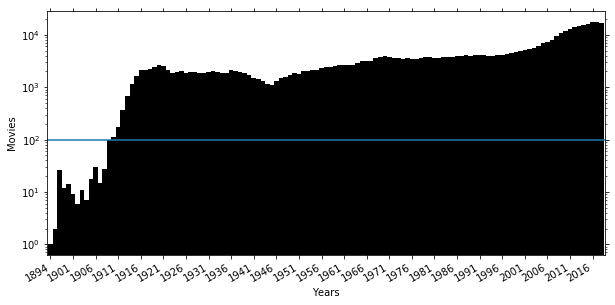

In [2]:
dfx = df.groupby(df["startYear"])._id.count()
ax = dfx.plot(kind="bar", figsize=(10,5), color='0.0', logy=True, width=1.0)
locator = ax.xaxis.get_major_locator()
locator.locs = locator.locs[::5]
formatter = ax.xaxis.get_major_formatter()
formatter.seq = formatter.seq[::5]
ax.get_figure().autofmt_xdate()
ax.axhline(y=100)
ax.set_ylabel('Movies')
ax.set_xlabel('Years')
ax.tick_params(which='both', bottom='off', top='off', left='off', right='off')

Considering only movies that have over 5k votes:

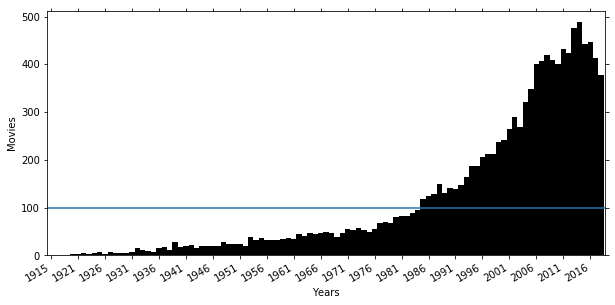

In [3]:
dfx = df[df.numVotes >= 5000].groupby(df["startYear"])._id.count()
ax = dfx.plot(kind="bar", figsize=(10,5), color='0.0', width=1.0)
locator = ax.xaxis.get_major_locator()
locator.locs = locator.locs[::5]
formatter = ax.xaxis.get_major_formatter()
formatter.seq = formatter.seq[::5]
ax.get_figure().autofmt_xdate()
ax.axhline(y=100)
ax.set_ylabel('Movies')
ax.set_xlabel('Years')
ax.tick_params(which='both', bottom='off', top='off', left='off', right='off')

We need to identify the top 100 movies released every year.
To accurately rank movies, we need at least 5k votes to normalize ratings.
We have at least 100 movies having over 5k votes only after 1985.
Hence, for the study we filter movies released before 1985.

In [4]:
df = df[df.startYear >= 1985]

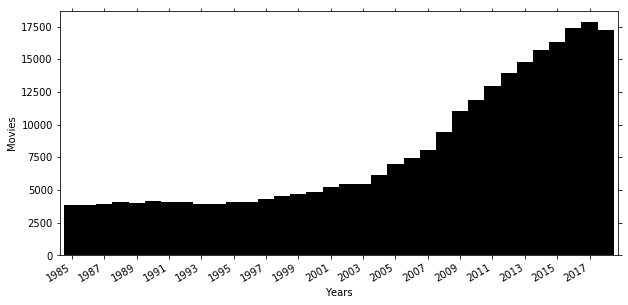

In [5]:
dfx = df.groupby(df["startYear"])._id.count()
ax = dfx.plot(kind="bar", figsize=(10,5), color='0.0', width=1.0)
locator = ax.xaxis.get_major_locator()
locator.locs = locator.locs[::2]
formatter = ax.xaxis.get_major_formatter()
formatter.seq = formatter.seq[::2]
ax.get_figure().autofmt_xdate()
ax.set_ylabel('Movies')
ax.set_xlabel('Years')
ax.tick_params(which='both', bottom='off', top='off', left='off', right='off')

Another view, now separating movies according to the number of received votes and binning 5-year periods:

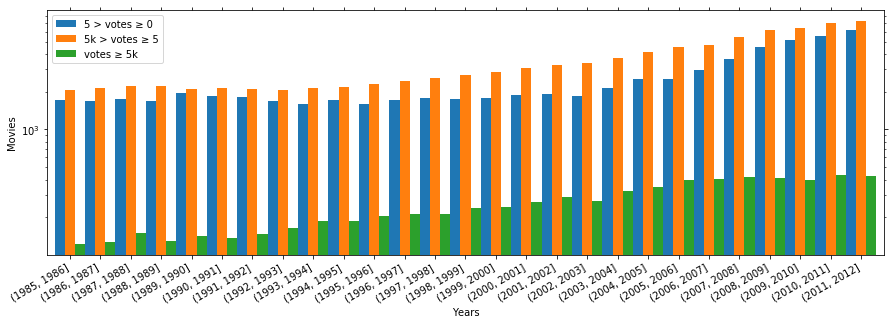

In [6]:
bins = np.arange(1985,2013, 1)
m1 = df.fillna(0).numVotes < 5
m2 = (df.numVotes >= 5) & (df.numVotes < 5000)
m3 = df.numVotes >= 5000
dfx = pd.DataFrame({
    '5 > votes ≥ 0': df[m1].groupby(pd.cut(df[m1].startYear, bins))._id.count(),
    '5k > votes ≥ 5': df[m2].groupby(pd.cut(df[m2].startYear, bins))._id.count(),
    'votes ≥ 5k': df[m3].groupby(pd.cut(df[m3].startYear, bins))._id.count()})
ax = dfx.plot(kind="bar", figsize=(15,5), logy=True, width=1)
ax.get_figure().autofmt_xdate()
ax.set_ylabel('Movies')
ax.set_xlabel('Years')
ax.tick_params(which='both', bottom='off', top='off', left='off', right='off')

The same as the previous view, but only considering movies in the top success group.

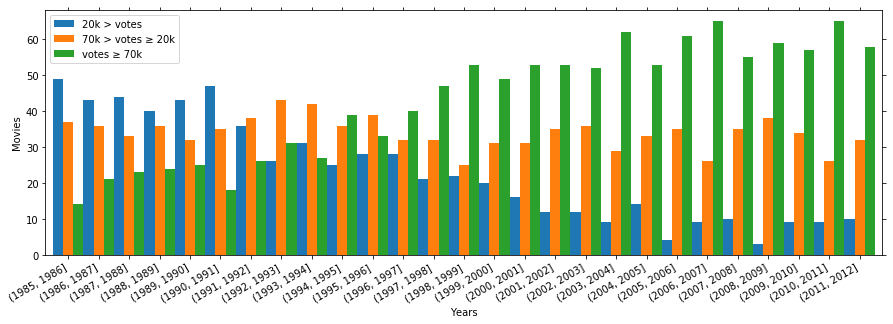

In [7]:
bins = np.arange(1985,2013, 1)
m = df.top100 == True
m1 = m & (df.numVotes < 20000)
m2 = m & (df.numVotes >= 20000) & (df.numVotes < 70000)
m3 = m & (df.numVotes >= 70000)
dfx = pd.DataFrame({
    '20k > votes': df[m1].groupby(pd.cut(df[m1].startYear, bins))._id.count(),
    '70k > votes ≥ 20k': df[m2].groupby(pd.cut(df[m2].startYear, bins))._id.count(),
    'votes ≥ 70k': df[m3].groupby(pd.cut(df[m3].startYear, bins))._id.count()})
ax = dfx.plot(kind="bar", figsize=(15,5), width=1)
ax.get_figure().autofmt_xdate()
ax.set_ylabel('Movies')
ax.set_xlabel('Years')
ax.tick_params(which='both', bottom='off', top='off', left='off', right='off')

## Ratings

A histogram of ratings (notice the y-log scale). Both the normalized and non-normalized ratings are shown.

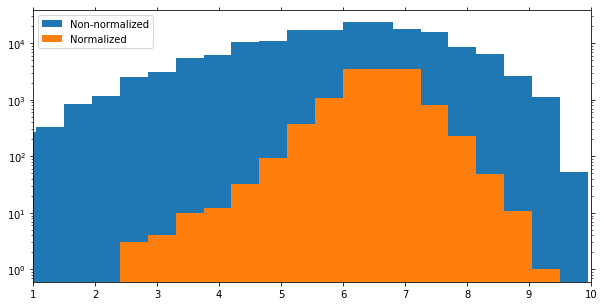

In [8]:
fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(df[~df.averageRating.isnull()].averageRating, bins=20)
b_heights, b_bins = np.histogram(df[~df.nrating.isnull()].nrating, bins=a_bins)
ax.bar(a_bins[:-1], a_heights, label="Non-normalized")
ax.bar(b_bins[:-1], b_heights, label="Normalized")
ax.legend()
ax.set_xlim((1,10))
ax.set_yscale('log')
fig.set_size_inches(10,5)
ax.tick_params(which='both', bottom='off', top='off', left='off', right='off')

The same as before, but only considering moving in the top success group.

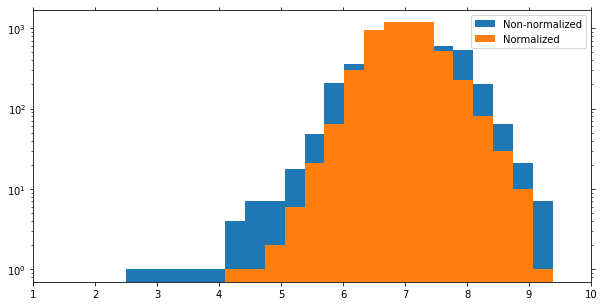

In [9]:
fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(df[df.top100 == True].averageRating, bins=20)
b_heights, b_bins = np.histogram(df[df.top100 == True].nrating, bins=a_bins)
ax.bar(a_bins[:-1], a_heights, label="Non-normalized")
ax.bar(b_bins[:-1], b_heights, label="Normalized")
ax.legend()
ax.set_xlim((1,10))
ax.set_yscale('log')
fig.set_size_inches(10,5)
ax.tick_params(which='both', bottom='off', top='off', left='off', right='off')

### Number of Votes Histogram

Histogram of the logarithm of the number of votes. Notice the y-scale. The peak at the start corresponds to movies with the minimum number of votes.

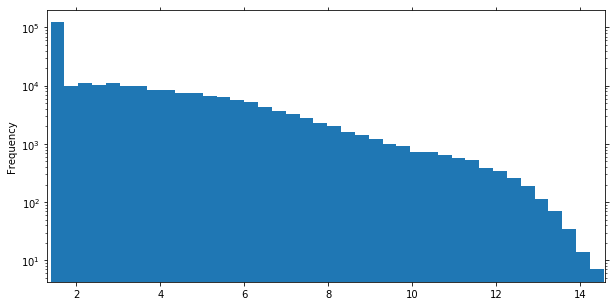

In [10]:
ax = df.log_votes.plot.hist(bins=40, figsize=(10,5))
ax.set_yscale('log')
ax.set_xlim((1.3,14.6))
ax.tick_params(which='both', bottom='off', top='off', left='off', right='off')

The same view as before, but only considering the top success group. Notice there is a huge discrepancy in the vote distribution group.

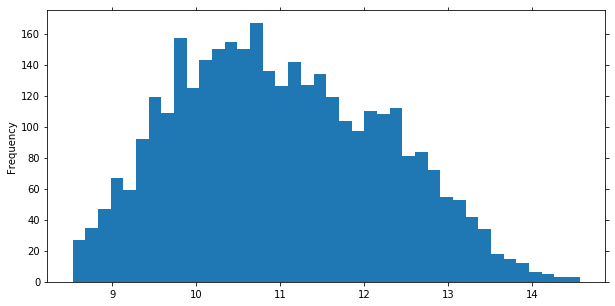

In [11]:
ax = df[df.top100 == True].log_votes.plot.hist(bins=40, figsize=(10,5))
ax.tick_params(which='both', bottom='off', top='off', left='off', right='off')

### Average Ratings per Number of Votes

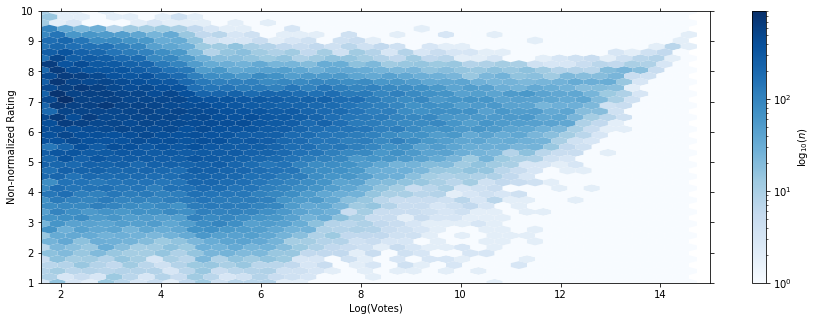

In [12]:
ax = df.plot.hexbin('log_votes', 'averageRating', bins='log',
                    edgecolors='w', linewidths=(0.01,), cmap=plt.cm.Blues,
                    gridsize=40, ylim=(1,10), xlim=(1.6,15),figsize=(15,5), sharex=False)
ax.set_ylabel('Non-normalized Rating')
ax.set_xlabel('Log(Votes)')
ax.tick_params(which='both', bottom='off', top='off', left='off', right='off')
cax = ax.get_figure().get_axes()[1] # Manually gets the colorbar axis.
cax.set_ylabel(r'$\log_{10}(n)$')
cax.tick_params(which='both', right='off')

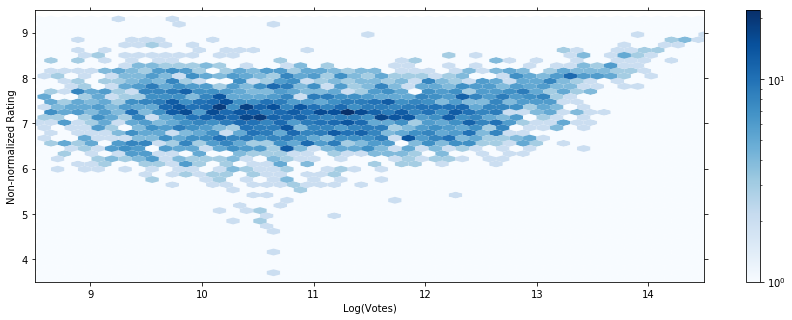

In [13]:
ax = df[df.top100 == True].plot.hexbin('log_votes', 'averageRating',bins='log',
                    edgecolors='w', linewidths=(0.01,), cmap=plt.cm.Blues,
                     sharex=False, gridsize=50, ylim=(3.5,9.5), xlim=(8.5,14.5), figsize=(15,5))
ax.set_ylabel('Non-normalized Rating')
ax.set_xlabel('Log(Votes)')
ax.tick_params(which='both', bottom='off', top='off', left='off', right='off')
cax = ax.get_figure().get_axes()[1] # Manually gets the colorbar axis.
cax.tick_params(which='both', right='off')

### Distribution of Ratings

Boxplot of normalized ratings distributions for movies grouped in 3-year periods. The boxplot to the left is the distribution of movies that made it to the top-100 yearly group; the boxplot to the right is the distribution among all movies that have a normalized rating (i.e., over 5k votes).

A noticeable and growing disparity among the distributions can be seen from the 2nd group onwards.

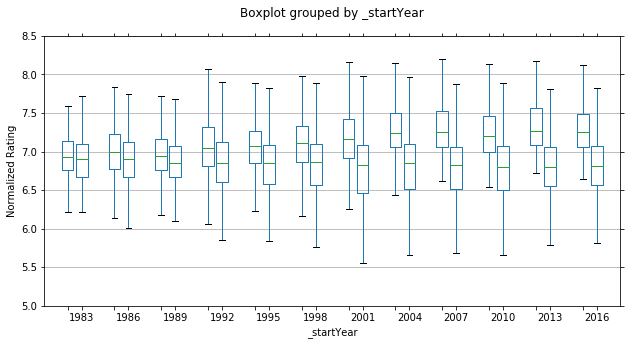

In [14]:
df['_startYear'] = df.startYear.map(lambda x: x - (x % 3 ))
pos = np.arange(df._startYear.nunique())
ax = df.boxplot('nrating', by='_startYear', positions=pos + 0.15, showfliers=False, figsize=(10,5), widths=0.25)
ax = df[df.top100].boxplot('nrating', by='_startYear', positions=pos - 0.15, showfliers=False, widths=0.25, ax=ax)
ax.set_ylim(5, 8.5)
ax.tick_params(which='both', bottom='off', top='off', left='off', right='off')
ax.set_ylabel('Normalized Rating')
ax.set_title('')
ax.xaxis.grid(False)

### Distribution of Votes

Boxplot of number of votes distributions for movies grouped in 3-year periods. The boxplot to the left is the distribution of movies that made it to the top-100 yearly group; the boxplot to the right is the distribution among all movies.

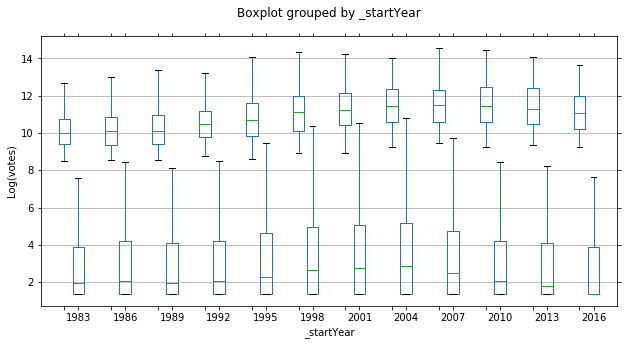

In [15]:
ax = df.boxplot('log_votes', by='_startYear', positions=pos + 0.15, showfliers=False, figsize=(10,5), widths=0.25)
ax = df[df.top100].boxplot('log_votes', by='_startYear', positions=pos - 0.15, showfliers=False, widths=0.25, ax=ax)
#ax.set_ylim(5, 8.5)
ax.tick_params(which='both', bottom='off', top='off', left='off', right='off')
ax.set_ylabel('Log(votes)')
ax.set_title('')
ax.xaxis.grid(False)

How normalized ratings are distributed from groups of movies that received different number of votes.

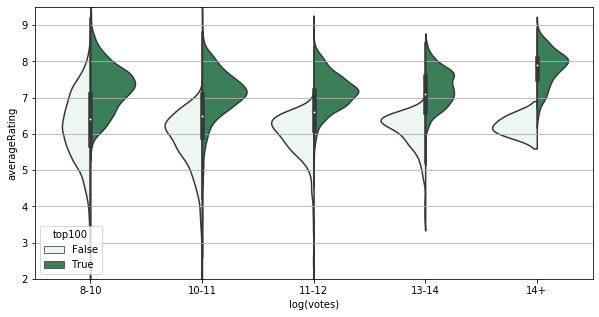

In [16]:
def name_bins(g):
    g['log(votes)'] = g.name
    return g
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
break_points = [8, 10, 11, 12, 13, 14]
labels = ["8-10", "10-11", "11-12", "13-14", "14+"]
dfx = df[~df.nrating.isnull()]
dfx = dfx.groupby(pd.cut(dfx.log_votes, break_points, labels=labels))
dfx = dfx.apply(name_bins)
ax = sns.violinplot(data=dfx, x="log(votes)", y="averageRating", hue="top100", split=True, showmeans=False,
        showmedians=True, showfliers=False, order=labels, color="seagreen")
ax.set_ylim(2,9.5)
ax.yaxis.grid(True)